<a href="https://colab.research.google.com/github/yeonsu-park12/weatherwise_yeonsu-park/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [43]:
!pip install requests matplotlib pyinputplus

In [44]:
import os


## 📦 Setup and Configuration
Import required packages and setup environment.

In [45]:
import requests  # for API calls
import matplotlib.pyplot as plt  # for plotting graphs
import re  # for simple NLP parsing
from datetime import datetime, timedelta  # for handling dates

# Optional: if you need to set API endpoints as environment variables
# os.environ['WEATHER_API_URL'] = 'https://wttr.in'

## 🌤️ Weather Data Functions



In [46]:
def get_weather_data(city, format_type='json'):
    """
    Fetch weather data from wttr.in API.
    Args:
        city (str): City name.
        format_type (str): 'json' or 'plaintext' format.
    Returns:
        dict or None: JSON data or prints plaintext weather info.
    """
    url_base = os.getenv('WEATHER_API_URL', 'https://wttr.in')

    try:
        if format_type.lower() == 'json':
            url = f"{url_base}/{city}?format=j1"
        else:
            url = f"{url_base}/{city}"

        response = requests.get(url, timeout=10)
        response.raise_for_status()

        if format_type.lower() == 'json':
            return response.json()
        else:
            print(response.text)
            return None

    except requests.exceptions.RequestException as e:
        print(f"⚠️ Error fetching weather data: {e}")
        return None


## ⭐ Emoji Mapping for Weather



In [47]:
def get_weather_emoji(weather_desc):
    """
    Map weather description to an emoji for visualization.
    """
    desc = weather_desc.lower()

    rain_keywords = ['rain', 'drizzle', 'shower', 'thundery outbreaks', 'downpour', 'wet']
    snow_keywords = ['snow', 'blizzard', 'sleet', 'ice', 'hail', 'flurry']
    cloud_keywords = ['cloud', 'overcast', 'mist', 'fog', 'haze', 'partly cloudy', 'scattered clouds']
    sun_keywords = ['sunny', 'clear', 'fair', 'hot', 'bright', 'clear skies', 'clear weather']
    wind_keywords = ['wind', 'gale', 'storm', 'breeze', 'gust']

    # Check for weather types
    if any(word in desc for word in rain_keywords):
        if 'thunder' in desc or 'storm' in desc:
            return '⛈️'
        elif 'light' in desc or 'patchy' in desc:
            return '🌦️'
        else:
            return '🌧️'
    elif any(word in desc for word in snow_keywords):
        if 'light' in desc or 'patchy' in desc:
            return '🌨️'
        else:
            return '❄️'
    elif any(word in desc for word in cloud_keywords):
        if 'fog' in desc or 'mist' in desc:
            return '🌫️'
        elif 'overcast' in desc:
            return '☁️'
        else:
            return '⛅'
    elif any(word in desc for word in sun_keywords):
        return '☀️'
    elif any(word in desc for word in wind_keywords):
        return '💨'
    else:
        return '🌡️'


## 📊 Visualisation Functions - Temperature & Precipitation

In [48]:
# Temperature Visualization
def visualize_temperature(city):
    """
    Display average temperature for the next 3 days.
    """
    data = get_weather_data(city)
    if not data:
        print("No weather data available.")
        return

    dates = [day['date'] for day in data['weather']]
    avg_temps = [sum(int(hour['tempC']) for hour in day['hourly'])/len(day['hourly'])
                 for day in data['weather']]

    plt.figure(figsize=(7,4))
    plt.plot(dates, avg_temps, marker='o', linestyle='-', linewidth=2)
    plt.title(f"Average Temperature in {city} (Next 3 Days)")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.show()


In [49]:
# Precipitation Visualization
def visualize_precipitation(city, day_index=0):
    """
    Plot hourly precipitation and chance of rain.
    """
    data = get_weather_data(city)
    if not data:
        print("Failed to get weather data.")
        return

    hourly = data['weather'][day_index]['hourly']
    times = [f"{int(h['time'])//100:02d}:00" for h in hourly]
    precip_mm = [float(h['precipMM']) for h in hourly]
    rain_chance_pct = [int(h['chanceofrain']) for h in hourly]

    fig, precip_ax = plt.subplots()

    precip_ax.plot(times, precip_mm, 'b-o', label='Precipitation (mm)')
    precip_ax.set_xlabel('Hour of Day')
    precip_ax.set_ylabel('Precipitation (mm)', color='b')
    precip_ax.tick_params(axis='y', labelcolor='b')

    chance_ax = precip_ax.twinx()
    chance_ax.plot(times, rain_chance_pct, 'g--x', label='Chance of Rain (%)')
    chance_ax.set_ylabel('Chance of Rain (%)', color='g')
    chance_ax.tick_params(axis='y', labelcolor='g')

    day_label = ['Today','Tomorrow','Day After Tomorrow'][day_index]
    plt.title(f"{day_label} Precipitation & Rain Chance in {city}")
    plt.grid(True)
    plt.show()


## 🤖 Natural Language Processing

In [50]:
def suggest_activity(temp, activity_type, activity_name, weather_desc):
    """
    Generate activity suggestion based on temperature, activity type and weather.
    """
    temp = float(temp)
    desc_lower = weather_desc.lower()
    bad_weather_keywords = ['rain', 'thunder', 'fog', 'mist', 'shower', 'snow', 'drizzle', 'downpour', 'blizzard']

    bad_weather = any(word in desc_lower for word in bad_weather_keywords)

    if activity_type == "Outdoor":
        if bad_weather or temp < 15:
            suggestion = f"Bad weather or cold ({temp}°C). Not recommended for {activity_name}."
        elif 15 <= temp <= 30:
            suggestion = f"Perfect temperature ({temp}°C) for {activity_name}."
        else:
            suggestion = f"Very hot ({temp}°C). Be careful doing {activity_name} outdoors."
    else:
        if bad_weather or temp < 15:
            suggestion = f"Indoor activity {activity_name} is best choice due to weather."
        else:
            suggestion = f"Indoor activity {activity_name} is fine. You could also try outdoor activities."

    return suggestion

def parse_weather_question(question, city):
    """
    Interpret user question and generate suggestion.
    """
    time_pattern = r"(today|tomorrow|after[-\s]?tomorrow|day[-\s]?after[-\s]?tomorrow)"
    outdoor_pattern = r"(run|swim|sports|tennis|cycling|hiking|jogging|fishing|camping)"
    indoor_pattern = r"(cooking|reading|studying|watching movies|baking|painting|knitting|gaming)"

    time_match = re.search(time_pattern, question, re.IGNORECASE)
    outdoor_match = re.search(outdoor_pattern, question, re.IGNORECASE)
    indoor_match = re.search(indoor_pattern, question, re.IGNORECASE)

    time_text = time_match.group(1).lower() if time_match else "today"
    if outdoor_match:
        activity_type = "Outdoor"
        activity_name = outdoor_match.group(1)
    elif indoor_match:
        activity_type = "Indoor"
        activity_name = indoor_match.group(1)
    else:
        print("Could not detect activity.")
        return

    target_date = datetime.now()
    if time_text == "tomorrow":
        target_date += timedelta(days=1)
    elif "after" in time_text:
        target_date += timedelta(days=2)

    weather_data = get_weather_data(city)
    if not weather_data:
        print("No weather data.")
        return

    day_index = 0 if time_text=="today" else 1 if time_text=="tomorrow" else 2
    target_day = weather_data['weather'][day_index]
    avg_temp = sum(int(h['tempC']) for h in target_day['hourly']) / len(target_day['hourly'])
    desc = target_day['hourly'][4]['weatherDesc'][0]['value']
    emoji = get_weather_emoji(desc)

    suggestion = suggest_activity(avg_temp, activity_type, activity_name, desc)

    print("\n" + "="*40)
    print(f"City       : {city}")
    print(f"Date       : {time_text.capitalize()}")
    print(f"Activity   : {activity_name} ({activity_type})")
    print(f"Weather    : {emoji} - {desc}")
    print(f"Temperature: Avg {avg_temp:.1f}°C")
    print(f"Suggestion : {suggestion}")
    print("="*40 + "\n")

## 🧭 User Interface

In [51]:
def main():
    print("="*50)
    print("🌦 WELCOME TO WEATHERWISE 🌦".center(50))
    print("="*50)

    name = input("Enter your name: ")
    city = input("Enter your city: ")

    while True:
        print("\nMenu Options:")
        print("1. View 3-day Temperature Chart")
        print("2. View Precipitation & Rain Chance Graph")
        print("3. Ask Weather Question / Activity Suggestion")
        print("4. Change City")
        print("5. Exit")

        choice = input("Select an option (1-5): ").strip()
        if choice == "1":
            visualize_temperature(city)
        elif choice == "2":
            print("Select day: 1-Today, 2-Tomorrow, 3-Day after Tomorrow")
            day_choice = input("Choice: ").strip()
            day_index = int(day_choice)-1 if day_choice in ['1','2','3'] else 0
            visualize_precipitation(city, day_index)
        elif choice == "3":
            question = input("Enter your weather question: ")
            parse_weather_question(question, city)
        elif choice == "4":
            city = input("Enter new city: ")
            print(f"City changed to {city}")
        elif choice == "5":
            print(f"Goodbye, {name}! Stay weather-wise 🌤")
            break
        else:
            print("Invalid choice. Enter 1-5.")

## 🧩 Main Application Logic

            🌦 WELCOME TO WEATHERWISE 🌦            
Enter your name: Yeonsu
Enter your city: Perth

Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 1


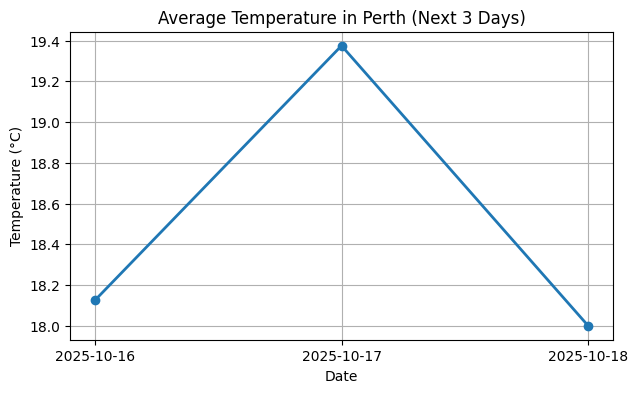


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 2
Select day: 1-Today, 2-Tomorrow, 3-Day after Tomorrow
Choice: 2


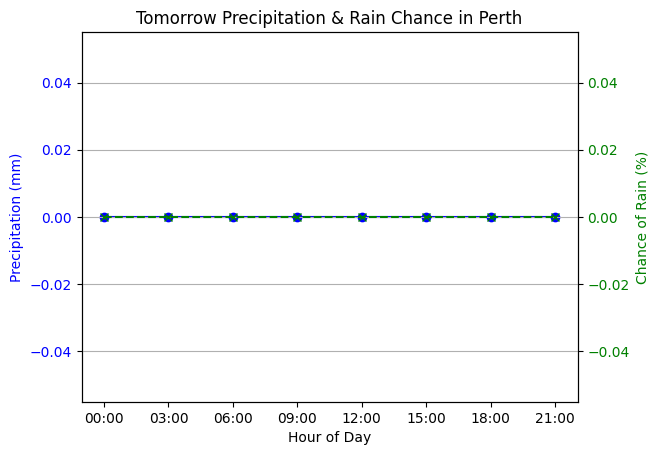


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 3
Enter your weather question: Can I go running tomorrow?

City       : Perth
Date       : Tomorrow
Activity   : run (Outdoor)
Weather    : ☀️ - Sunny
Temperature: Avg 19.4°C
Suggestion : Perfect temperature (19.375°C) for run.


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 3
Enter your weather question: Should I stay inside for painting today?

City       : Perth
Date       : Today
Activity   : painting (Indoor)
Weather    : ☀️ - Sunny
Temperature: Avg 18.1°C
Suggestion : Indoor activity painting is fine. You could also try outdoor activities.


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Sugges

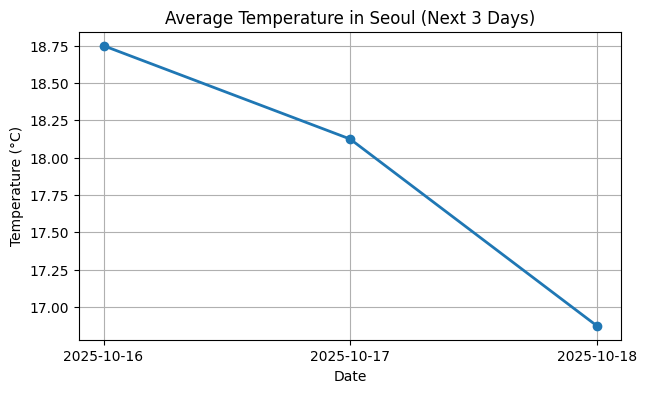


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 2
Select day: 1-Today, 2-Tomorrow, 3-Day after Tomorrow
Choice: 3


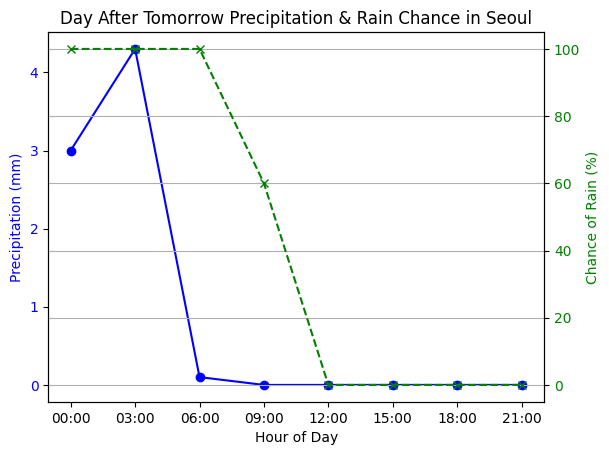


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 3
Enter your weather question: Is it raining for camping after tomorrow?

City       : Seoul
Date       : After tomorrow
Activity   : camping (Outdoor)
Weather    : ☀️ - Sunny
Temperature: Avg 16.9°C
Suggestion : Perfect temperature (16.875°C) for camping.


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Question / Activity Suggestion
4. Change City
5. Exit
Select an option (1-5): 3
Enter your weather question: Is it ok for studying today?

City       : Seoul
Date       : Today
Activity   : studying (Indoor)
Weather    : ☁️ - Overcast 
Temperature: Avg 18.8°C
Suggestion : Indoor activity studying is fine. You could also try outdoor activities.


Menu Options:
1. View 3-day Temperature Chart
2. View Precipitation & Rain Chance Graph
3. Ask Weather Quest

In [52]:
if __name__ == "__main__":
    main()

## 🧪 Testing and Examples

In [ ]:
# Example prompt:
# - City: Perth
# - Outdoor Activity Question: Can I go running tomorrow?
# - Indoor Activity Question: Should I stay inside for painting today?

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.